In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras import layers
from tensorflow import keras
import tarfile
import numpy as np
import os

In [ ]:
df = pd.read_csv(r'LJSpeech-1.1\metadata.csv', sep="|", header=None, quoting=3)
df.columns = ["fileName", "trasncription", "normalized transcription"]
df.head()

,fileName,trasncription,normalized transcription
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [20]:
df = df[["fileName", "normalized transcription"]]
df.head()

,fileName,normalized transcription
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...


In [34]:
df.isna().sum()

fileName                    0
normalized transcription    0
dtype: int64

In [74]:
data_path = r'LJSpeech-1.1'
wav_path = r'D:\Voice_recog\audio_detection_ctc\LJSpeech-1.1\wavs'
batch_size = 32
split = int(len(df["fileName"]) * 0.8)
df_train = df[: split]
df_val = df[split:]

In [75]:
char = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = layers.StringLookup(vocabulary = char, num_oov_indices = 1, oov_token = "")
num_to_char = layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), invert = True, oov_token = "", num_oov_indices = 1)
print(char_to_num.get_vocabulary())

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']


In [76]:
print(wav_path)

D:\Voice_recog\audio_detection_ctc\LJSpeech-1.1\wavs


In [105]:
frame_length = 256
frame_step = 128
fft_length = 384

def decode_single_sample(wav_file, label):
    file_path = tf.strings.join([wav_path, wav_file + ".wav",], separator = os.path.sep)
    file = tf.io.read_file(file_path)
    aud, _ = tf.audio.decode_wav(file)
    aud = tf.squeeze(aud, axis = -1) #to remove 2channel of audio, mono audio is needed
    aud = tf.cast(aud, tf.float32)

    spectogram = tf.signal.stft(aud, frame_length = frame_length, frame_step = frame_step, fft_length = fft_length)
    spectogram = tf.abs(spectogram)
    spectogram = tf.math.pow(spectogram, 0.5)

    #normalize
    means = tf.math.reduce_mean(spectogram)
    std = tf.math.reduce_std(spectogram)
    spectogram = (spectogram - means) / (std + 1e-10)

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)

    return spectogram, label

In [106]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["fileName"]), list(df_train["normalized transcription"]))
)
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["fileName"]), list(df_val["normalized transcription"]))
)

train_dataset = (
    train_dataset.map(decode_single_sample, num_parallel_calls = tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)
validation_dataset = (
    validation_dataset.map(decode_single_sample, num_parallel_calls = tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

AttributeError: 'function' object has no attribute 'display'

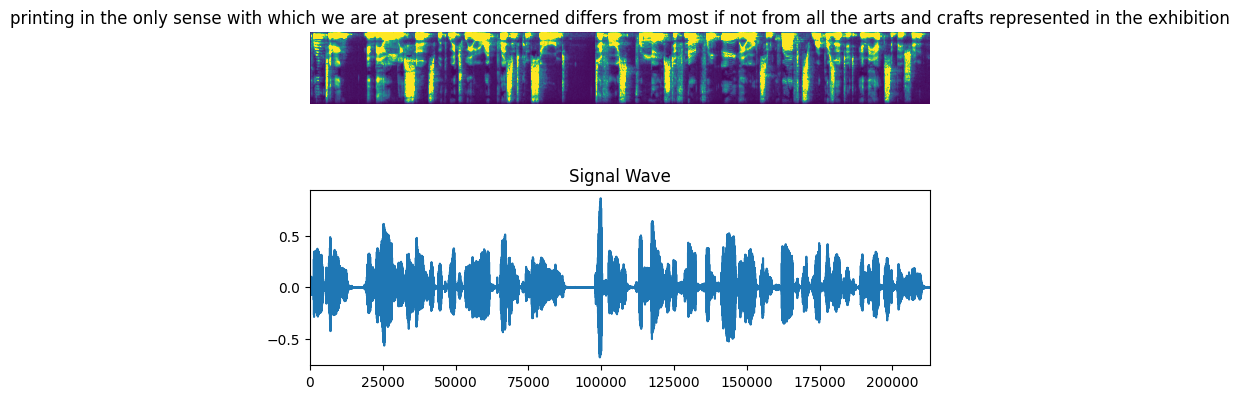

In [107]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(os.path.join(wav_path ,list(df_train["fileName"])[0]) + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [117]:
for batch in train_dataset.take(1):
    print(len(batch[0]))
    print(batch[1][0])
    label = tf.strings.reduce_join(num_to_char(batch[1][0])).numpy().decode("utf-8")
    print(label)

32
tf.Tensor(
[16 18  9 14 20  9 14  7  0 30  9 14 30 20  8  5 30 15 14 12 25 30 19  5
 14 19  5 30 23  9 20  8 30 23  8  9  3  8 30 23  5 30  1 18  5 30  1 20
 30 16 18  5 19  5 14 20 30  3 15 14  3  5 18 14  5  4  0 30  4  9  6  6
  5 18 19 30  6 18 15 13 30 13 15 19 20 30  9  6 30 14 15 20 30  6 18 15
 13 30  1 12 12 30 20  8  5 30  1 18 20 19 30  1 14  4 30  3 18  1  6 20
 19 30 18  5 16 18  5 19  5 14 20  5  4 30  9 14 30 20  8  5 30  5 24  8
  9  2  9 20  9 15 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(168,), dtype=int64)
printing in the only sense with which we are at present concerned differs from most if not from all the arts and crafts represented in the exhibition


In [118]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype = 'int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype = 'int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")

    input_length = input_length * tf.ones(shape = (batch_len, 1), dtyep = "int64")
    label_length = label_length * tf.ones(shape = (batch_len, 1), dtyep = "int64")

    loss = k.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    
    return loss

In [119]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=ctc_loss)
    return model

In [120]:
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)